<a href="https://colab.research.google.com/github/iTosy/Task_1/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install autoconf
!sudo apt-get install libtool
!sudo apt-get install liblapack-dev libblas-dev libfftw3-dev
!rm -rf itpp
!git clone https://github.com/iamviji/itpp.git # original one had compilation issue, did minor signle line change after forking
!ls;cd itpp;ls;mkdir -p build1 build2; cd build1 ; cmake cmake ..;make ;make install
!rm -rf py-itpp
!git clone https://github.com/vidits-kth/py-itpp.git
!pip3 install pybind11
!cd py-itpp;./install_prerequisites_python3.sh;make install;pip3 install -e .
!cd py-itpp; ls ; pip3 install -e .
!cat py-itpp/setup.py
#following 3 lines are added to resolve the issue
import sys
sys.path.append('./py-itpp/lib')
!cp -rf py-itpp/lib/itpp py-itpp/lib/pyitpp # import itpp is not working, after this hack i started to work


Reading package lists... Done
Building dependency tree       
Reading state information... Done
autoconf is already the newest version (2.69-11.1).
autoconf set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libtool-doc gcj-jdk
The following NEW packages will be installed:
  libtool
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 161 kB of archives.
After this operation, 1,227 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libtool all 2.4.6-14 [161 kB]
Fetched 161 kB in 0s (1,714 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unabl

In [2]:
import tensorflow as tf
import numpy as np


In [8]:
def block_error_ratio_autoencoder_awgn(snrs_db, block_size, channel_use, batch_size, nrof_steps):
    
    print('block_size %d'%(block_size))
    print('channel_use %d'%(channel_use))
    
    rate = float(block_size)/float(channel_use)
    print('rate %0.2f'%(rate))
    
    '''The input is one-hot encoded vector for each codeword'''
    alphabet_size = pow(2, block_size)
    alphabet = np.eye(alphabet_size, dtype = 'float32') # One-hot encoded values
    
    '''Repeat the alphabet to create training and test datasets'''
    train_dataset = np.transpose(np.tile(alphabet, int(batch_size)))
    test_dataset = np.transpose(np.tile(alphabet, int(batch_size * 1000)))
    
    print('--Setting up autoencoder graph--')
    input, output, noise_std_dev, h_norm = _implement_autoencoder(alphabet_size, channel_use)
    
    print( '--Setting up training scheme--')
    train_step = _implement_training(output, input)
    
    print('--Setting up accuracy--')
    accuracy = _implement_accuracy(output, input)

    print('--Starting the tensorflow session--')
    sess = _setup_interactive_tf_session()
    _init_and_start_tf_session(sess)
    
    print('--Training the autoencoder over awgn channel--')
    _train(train_step, input, noise_std_dev, nrof_steps, train_dataset, snrs_db, rate, accuracy)
    
    print('--Evaluating autoencoder performance--')
    bler = _evaluate(input, noise_std_dev, test_dataset, snrs_db, rate, accuracy)
    
    print('--Closing the session--')
    _close_tf_session(sess)
    
    return bler
    
def _setup_tf_session():
    return tf.Session()

def _setup_interactive_tf_session():
    return tf.compat.v1.InteractiveSession()

def _init_and_start_tf_session():
    init = tf.compat.v1.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    return sess

def _init_and_start_tf_session(sess):
    sess.run(tf.compat.v1.global_variables_initializer())
    
def _close_tf_session(sess):
    sess.close
    
def _weight_variable(shape):
    initial = tf.random.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def _bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)

def _implement_autoencoder(input_dimension, encoder_dimension):
    input = tf.compat.v1.placeholder(tf.float32, [None, input_dimension])
    
    '''Densely connected encoder layer'''
    W_enc1 = _weight_variable([input_dimension, input_dimension])
    b_enc1 = _bias_variable([input_dimension])
    
    h_enc1 = tf.nn.relu(tf.matmul(input, W_enc1) + b_enc1)
    
    '''Densely connected encoder layer'''
    W_enc2 = _weight_variable([input_dimension, encoder_dimension])
    b_enc2 = _bias_variable([encoder_dimension])
    
    h_enc2 = tf.matmul(h_enc1, W_enc2) + b_enc2
    
    '''Normalization layer'''
    normalization_factor = tf.math.reciprocal(tf.sqrt(tf.reduce_sum(tf.square(h_enc2), 1))) * np.sqrt(encoder_dimension)
    h_norm = tf.multiply(tf.tile(tf.expand_dims(normalization_factor, 1), [1, encoder_dimension]), h_enc2)

    '''AWGN noise layer'''
    noise_std_dev = tf.compat.v1.placeholder(tf.float32)
    channel = tf.random.normal(tf.shape(h_norm), stddev=noise_std_dev)
    h_noisy = tf.add(h_norm, channel)
    
    '''Densely connected decoder layer'''
    W_dec1 = _weight_variable([encoder_dimension, input_dimension])
    b_dec1 = _bias_variable([input_dimension])
    
    h_dec1 = tf.nn.relu(tf.matmul(h_noisy, W_dec1) + b_dec1)
        
    '''Output layer'''
    W_out = _weight_variable([input_dimension, input_dimension])
    b_out = _bias_variable([input_dimension])
     
    output = tf.nn.softmax(tf.matmul(h_dec1, W_out) + b_out)
    
    return (input, output, noise_std_dev, h_norm)
    
def _implement_training(output, input):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = output, labels = input))
    
#     train_step = tf.train.GradientDescentOptimizer(1e-2).minimize(cross_entropy) 
    train_step = tf.compat.v1.train.AdamOptimizer(1e-3).minimize(cross_entropy)
    
    return train_step

def _implement_accuracy(output, input):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(input, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

def _train(train_step, input, noise_std_dev, nrof_steps, training_dataset, snrs_db, rate, accuracy):
    print('--Training--')
    print('number of steps %d'%(nrof_steps))
    snr = max(snrs_db)
    snrs_rev = snrs_db[::-1]
    for snr in snrs_rev[0:1]: # Train with higher SNRs first
        print('training snr %0.2f db'%(snr))
        noise = np.sqrt(1.0 / (2 * rate * pow(10, 0.1 * snr)))
        for i in range(int(nrof_steps)):
            batch = training_dataset
            np.random.shuffle(batch)
            if (i + 1) % (nrof_steps/10) == 0: # i = 0 is the first step
                print('training step %d'%(i + 1))
            train_step.run(feed_dict={input: batch, noise_std_dev: noise})
        print('training accuracy %0.4f'%(accuracy.eval(feed_dict={input: batch, noise_std_dev: noise})))

def _evaluate(input, noise_std_dev, test_dataset, snrs_db, rate, accuracy):
    print('--Evaluating NN performance on test dataset--')
    bler = []
    for snr in snrs_db:
        noise = np.sqrt(1.0 / (2 * rate * pow(10, 0.1 * snr)))
        acc = accuracy.eval(feed_dict={input: test_dataset, noise_std_dev: noise})
        bler.append(1.0 - acc)
    return bler

In [4]:
import pyitpp as itpp
from matplotlib import pyplot as plt

In [5]:
def block_error_ratio_hamming_awgn(snr_db, block_size):
    
    mapping_k_m = {4: 3} # Mapping from k (block size) to m. m = 3 implies (7,4) code
    m = mapping_k_m[block_size]
     
    '''Hamming encoder and decoder instance'''
    hamm = itpp.comm.Hamming_Code(m)
    n = pow(2,m) - 1 # channel use
    rate = float(block_size)/float(n)
    
    '''Generate random bits'''
    nrof_bits = 10000 * block_size
    source_bits = itpp.randb(nrof_bits)
    
    '''Encode the bits'''
    encoded_bits = hamm.encode(source_bits)
    
    '''Modulate the bits'''
    modulator_ = itpp.comm.modulator_2d()
    constellation = itpp.cvec('-1+0i, 1+0i')
    symbols = itpp.ivec('0, 1')
    modulator_.set(constellation, symbols)
    tx_signal = modulator_.modulate_bits(encoded_bits)
    
    '''Add the effect of channel to the signal'''
    noise_variance = 1.0 / (rate * pow(10, 0.1 * snr_db))
    noise = itpp.randn_c(tx_signal.length())
    noise *= itpp.math.sqrt(noise_variance)
    rx_signal = tx_signal + noise
    
    '''Demodulate the signal'''
    demodulated_bits = modulator_.demodulate_bits(rx_signal)
    
    '''Decode the received bits'''
    decoded_bits = hamm.decode(demodulated_bits) 
    
    '''Calculate the block error ratio'''
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(source_bits, decoded_bits)
    return blerc.get_errorrate()

In [6]:
def block_error_ratio_uncoded_awgn(snr_db, block_size):
    '''Generate random bits'''
    nrof_bits = 3 * 10000 * block_size
    source_bits = itpp.randb(nrof_bits)
    rate = 1.0
    
    '''Modulate the bits'''
    modulator_ = itpp.comm.modulator_2d()
    constellation = itpp.cvec('-1+0i, 1+0i')
    symbols = itpp.ivec('0, 1')
    modulator_.set(constellation, symbols)
    tx_signal = modulator_.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    noise_variance = 1.0 / (rate * pow(10, 0.1 * snr_db))
    noise = itpp.randn_c(tx_signal.length())
    noise *= itpp.math.sqrt(noise_variance)
    rx_signal = tx_signal + noise
    
    '''Demodulate the signal'''
    demodulated_bits = modulator_.demodulate_bits(rx_signal)
    
    '''Calculate the block error ratio'''
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(source_bits, demodulated_bits)
    return blerc.get_errorrate()

-------Evaluating BLER for Uncoded (4,4) over AWGN-------
-------Evaluating BLER for Hamming (7,4) over AWGN-------
-------Evaluating BLER for Autoencoder (7,4) over AWGN-------
block_size 4
channel_use 7
rate 0.57
--Setting up autoencoder graph--
--Setting up training scheme--
--Setting up accuracy--
--Starting the tensorflow session--
--Training the autoencoder over awgn channel--
--Training--
number of steps 50000
training snr 8.00 db
training step 5000
training step 10000
training step 15000
training step 20000
training step 25000
training step 30000
training step 35000
training step 40000
training step 45000
training step 50000
training accuracy 1.0000
--Evaluating autoencoder performance--
--Evaluating NN performance on test dataset--
--Closing the session--
-------Plotting results-------
-------Evaluating BLER for Uncoded BPSK (2,2) over AWGN-------
-------Evaluating BLER for Autoencoder (2,2) over AWGN-------
block_size 2
channel_use 2
rate 1.00
--Setting up autoencoder graph--

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


training step 5000
training step 10000
training step 15000
training step 20000
training step 25000
training step 30000
training step 35000
training step 40000
training step 45000
training step 50000
training accuracy 1.0000
--Evaluating autoencoder performance--
--Evaluating NN performance on test dataset--
--Closing the session--
-------Plotting results-------
-------Evaluating BLER for Uncoded BPSK (8,8) over AWGN-------
-------Evaluating BLER for Autoencoder (8,8) over AWGN-------
block_size 8
channel_use 8
rate 1.00
--Setting up autoencoder graph--
--Setting up training scheme--
--Setting up accuracy--
--Starting the tensorflow session--
--Training the autoencoder over awgn channel--
--Training--
number of steps 12500
training snr 8.00 db
training step 1250
training step 2500
training step 3750
training step 5000
training step 6250
training step 7500
training step 8750
training step 10000
training step 11250
training step 12500
training accuracy 0.9961
--Evaluating autoencoder perf

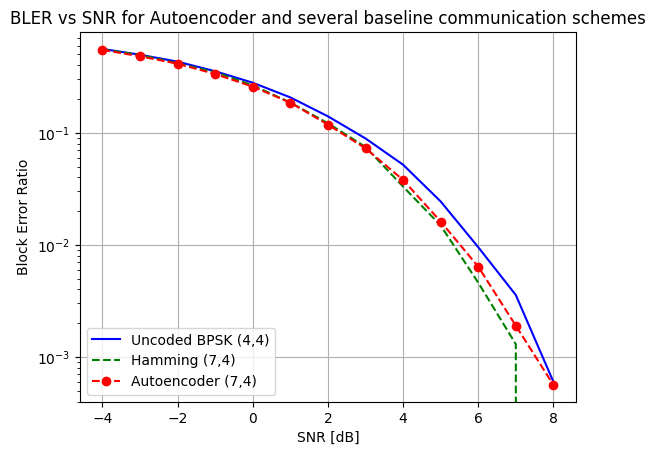

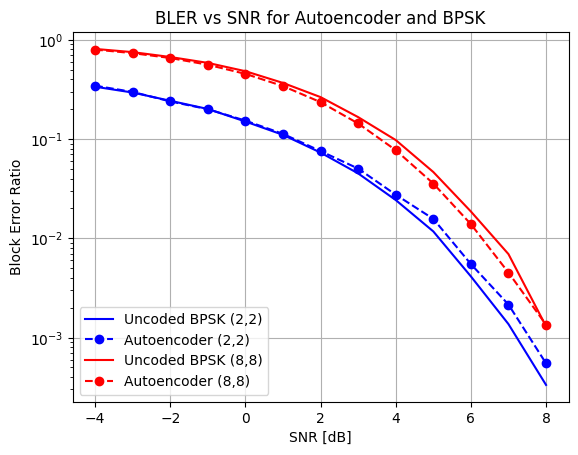

In [9]:
from matplotlib import pyplot as plt

''' Function:    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)
    Description: Block error ratio (BLER) vs Signal to Noise Ratio (SNR) 
                 curves for standard channel coding using Hamming codes, 
                 and for 'learnt' optimal representation that are obtained 
                 by training a neural network based autoencoder. Additive 
                 White Gaussian Noise (AWGN) channel is assumed. 
'''  
def _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db):
    
    channel_use = {4: 7} # Mapping to get length of Hamming codeblock from block length 
        
    '''BLER for uncoded BPSK over AWGN channel'''
    print('-------Evaluating BLER for Uncoded (%d,%d) over AWGN-------'%(block_size, block_size))
    bler_unc = [block_error_ratio_uncoded_awgn(snr, block_size) for snr in snrs_db]
     
    '''BLER for Hamming coded bits over AWGN channel'''
    print('-------Evaluating BLER for Hamming (%d,%d) over AWGN-------' %(channel_use[block_size], block_size))
    bler_hamming = [block_error_ratio_hamming_awgn(snr, block_size) for snr in snrs_db]
    
    '''BLER for Autoencoder coded bits over AWGN channel'''
    print('-------Evaluating BLER for Autoencoder (%d,%d) over AWGN-------' %(channel_use[block_size], block_size))
    batch_size = int(20/block_size)
    nrof_steps = int(200000/block_size)
    bler_autoenc = block_error_ratio_autoencoder_awgn(snrs_db, block_size, channel_use[block_size], batch_size, nrof_steps)
    
    print('-------Plotting results-------')
    plt.figure()
    plt.grid(True)
    plt.semilogy(snrs_db, bler_unc, ls = '-', c = 'b')
    plt.semilogy(snrs_db, bler_hamming, ls = '--', c = 'g')
    plt.semilogy(snrs_db, bler_autoenc, ls = '--', c = 'r', marker = 'o')
    plt.xlabel('SNR [dB]')
    plt.ylabel('Block Error Ratio')
    plt.legend(['Uncoded BPSK (%d,%d)'%(block_size, block_size), 
                'Hamming (%d,%d)'%(channel_use[block_size], block_size),
                'Autoencoder (%d,%d)'%(channel_use[block_size], block_size)],
               loc = 'lower left')
    plt.title('BLER vs SNR for Autoencoder and several baseline communication schemes')
    
    return (bler_hamming, bler_autoenc)

''' Function:    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)
    Description: Block error ratio (BLER) vs Signal to Noise Ratio (SNR) curves 
                 for uncoded transmission, and for 'learnt' optimal 
                 representations of the transmitted bits that are obtained by 
                 training a neural network based autoencoder. Additive White 
                 Gaussian Noise (AWGN) channel is assumed. 
'''  
def _bler_vs_snr_uncoded_autoenc(block_sizes, snrs_db):
    
    plt.figure()
    plt.grid(True)
    legend_strings = []
    colors = iter(list(['b', 'r', 'g', 'b', 'm']))
    for block_size in block_sizes:
        '''BLER for uncoded bits over AWGN channel'''
        print('-------Evaluating BLER for Uncoded BPSK (%d,%d) over AWGN-------' %(block_size, block_size))
        bler_unc = [block_error_ratio_uncoded_awgn(snr, block_size) for snr in snrs_db]
    
        '''BLER for Autoencoder coded  bits over AWGN channel'''
        print('-------Evaluating BLER for Autoencoder (%d,%d) over AWGN-------' %(block_size, block_size))
        batch_size = 10/block_size
        nrof_steps = 100000/block_size
        bler_autoenc = block_error_ratio_autoencoder_awgn(snrs_db, block_size, block_size, batch_size, nrof_steps)
        
        print('-------Plotting results-------')
        color = next(colors) 
        plt.semilogy(snrs_db, bler_unc, ls = '-', c = color)
        plt.semilogy(snrs_db, bler_autoenc, ls = '--', c = color, marker = 'o')
        
        legend_strings.append('Uncoded BPSK (%d,%d)'%(block_size, block_size))
        legend_strings.append('Autoencoder (%d,%d)'%(block_size, block_size))

    plt.xlabel('SNR [dB]')
    plt.ylabel('Block Error Ratio')
    plt.legend(legend_strings, loc = 'lower left')
    plt.title('BLER vs SNR for Autoencoder and BPSK')
    
if __name__ == '__main__':
    snrs_db = range(-4, 9)
    
    '''BLER for block size 4 with Autoencoder and Hamming'''
    block_size = 4
    channel_use = 7
    tf.compat.v1.disable_eager_execution()
    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)

    '''BLER for block sizes 2 and 8 with uncoded and Autoencoder'''
    block_sizes = [2, 8]
    _bler_vs_snr_uncoded_autoenc(block_sizes, snrs_db)
    
    plt.show()